In [38]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.metrics import confusion_matrix
from mlxtend.evaluate import bias_variance_decomp
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
def data_segmentation(df, y_label, window_size = 100, stride = 50):
    '''
    Segments the data into the same length and detach the whole dataset into X and y.
    
    df: data frame that contains all covariates and response variables
    y_label: the column name of the response variable that we want to predict
    window_size: the length of time included in a single data point
    stride: The interval between two closest segmented data point
    '''
    j = df.columns.get_loc(y_label)
    data = df.to_numpy()
    n = len(data)
    X = []
    y = []
    start = 0
    end = 0
    
    while start <= n - window_size:
        end = start + window_size - 1
        if data[start][j] == data[end][j] and data[start][0] + 0.01 > data[end][0]:
            X.append(data[start:(end+1),1:-7])
            y.append(data[start][j])
            start += stride
        else:
            while start + window_size - 1 < n:
                if data[start][j] != data[start+1][j]:
                    break
                start += 1
            start += 1
    return np.asarray(X), np.asarray(y)

In [47]:
def flatten_features(X_3d):
    """
    Converts the 3D (n_samples, n_timesteps, n_features) tensor 
    into a 2D (n_samples, n_features_flattened) matrix for XGBoost.

    We do this by calculating summary statistics for each feature across all timesteps.
    """
    n_samples, n_timesteps, n_features = X_3d.shape
    print(f"Flattening 3D data... Input shape: {X_3d.shape}")

    # We will calculate the slope for each feature, which requires a time vector
    # This is our 'x' for the linear regression
    timesteps_x = np.arange(n_timesteps).reshape(-1, 1)

    # Initialize a list to hold the feature vectors for all samples
    all_subject_features = []

    # Use tqdm for a progress bar, as this can be slow
    for i in range(n_samples):
        subject_data = X_3d[i, :, :]  # Shape (n_timesteps, n_features)
        
        # 1. Calculate basic statistics across time (axis=0)
        mean_features = np.mean(subject_data, axis=0)  # Shape (n_features,)
        std_features = np.std(subject_data, axis=0)    # Shape (n_features,)
        max_features = np.max(subject_data, axis=0)    # Shape (n_features,)
        min_features = np.min(subject_data, axis=0)    # Shape (n_features,)
        
        # 2. Get the last known value for each feature
        last_features = subject_data[-1, :]            # Shape (n_features,)


        # 4. Concatenate all our new features into a single 1D vector
        # We have 6 sets of stats, each with n_features
        subject_feature_vector = np.concatenate([
            mean_features,
            std_features,
            max_features,
            min_features,
            last_features,
        ])
        
        all_subject_features.append(subject_feature_vector)

    # Convert the list of vectors into our new 2D matrix
    X_flattened = np.array(all_subject_features)
    print(f"Flattening complete. New X shape: {X_flattened.shape}")
    return X_flattened

In [3]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

In [14]:
X_train, y_train = data_segmentation(df_train, "Locomotion")
X_test, y_test = data_segmentation(df_test, "Locomotion")

In [ ]:
num_classes = len(np.unique(y_train))
model = xgb.XGBClassifier(
        objective='multi:softmax',  # Use 'multi:softmax' for multi-class
        num_class=num_classes,      # Tell XGBoost how many classes to expect
        eval_metric='mlogloss',     # 'mlogloss' is for multi-class
        n_estimators=200,  # Number of trees
        learning_rate=0.1,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1  # Use all available CPU cores
    )
y_train[y_train == 5] = 3
y_test[y_test == 5] = 3
model.fit(X_train.mean(axis=1), y_train)
print("Training complete.")


# --- 6. Evaluate the Model ---
print("\n--- Model Evaluation ---")
y_pred = model.predict(X_test.mean(axis=1))


Training complete.

--- Model Evaluation ---
Accuracy: 89.06%


In [43]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')


# ROC curve multi-class classification
y_prob = model.predict_proba(X_test.mean(axis=1))
macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo", average="macro")

# confusion matrix
cm = confusion_matrix(y_test, y_pred)


# Print the evaluation metrics
print("Accuracy:", f"{accuracy:.4f}")
print("Precision:", f"{precision:.4f}")
print("Recall:", f"{recall:.4f}")
print("F1 Score:", f"{f1:.4f}")
print("AUC:", f"{macro_roc_auc_ovo:.4f}")

Accuracy: 0.8906
Precision: 0.8944
Recall: 0.8906
F1 Score: 0.8900
AUC: 0.9915


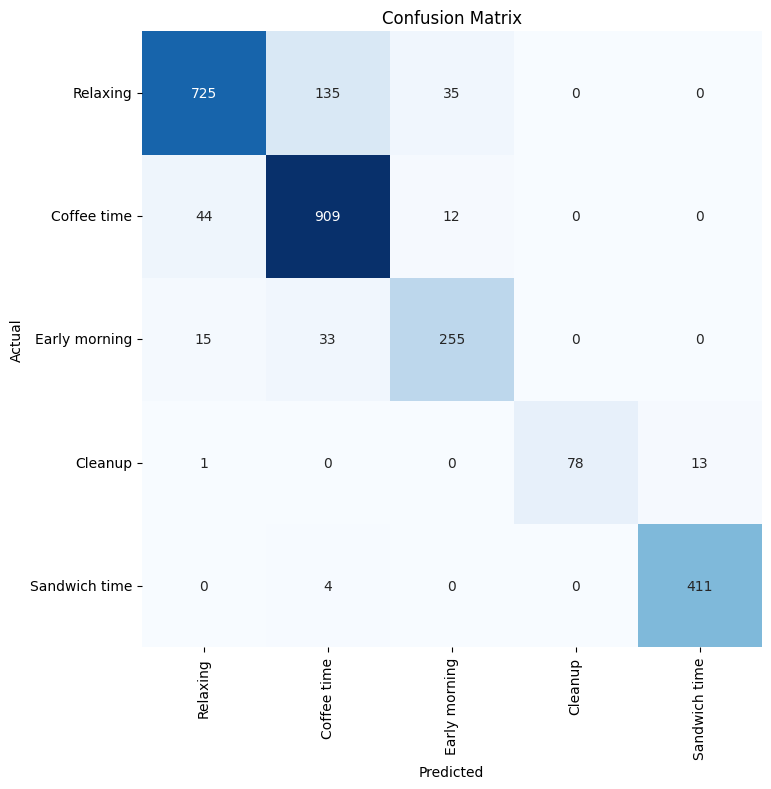

In [39]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)

# plot the confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xticks(np.arange(5)+0.5, ['Relaxing', 'Coffee time', 'Early morning', 'Cleanup', 'Sandwich time'], rotation=90)
plt.yticks(np.arange(5)+0.5, ['Relaxing', 'Coffee time', 'Early morning', 'Cleanup', 'Sandwich time'], rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [49]:
num_classes = len(np.unique(y_train))
model = xgb.XGBClassifier(
        objective='multi:softmax',  # Use 'multi:softmax' for multi-class
        num_class=num_classes,      # Tell XGBoost how many classes to expect
        eval_metric='mlogloss',     # 'mlogloss' is for multi-class
        n_estimators=200,  # Number of trees
        learning_rate=0.1,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1  # Use all available CPU cores
    )
y_train[y_train == 5] = 3
y_test[y_test == 5] = 3
model.fit(flatten_features(X_train), y_train)
print("Training complete.")


# --- 6. Evaluate the Model ---
print("\n--- Model Evaluation ---")
y_pred = model.predict(flatten_features(X_test))


Flattening 3D data... Input shape: (9850, 100, 242)
Flattening complete. New X shape: (9850, 1210)
Training complete.

--- Model Evaluation ---
Flattening 3D data... Input shape: (2670, 100, 242)
Flattening complete. New X shape: (2670, 1210)


In [50]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')


# ROC curve multi-class classification
y_prob = model.predict_proba(flatten_features(X_test))
macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo", average="macro")

# confusion matrix
cm = confusion_matrix(y_test, y_pred)


# Print the evaluation metrics
print("Accuracy:", f"{accuracy:.4f}")
print("Precision:", f"{precision:.4f}")
print("Recall:", f"{recall:.4f}")
print("F1 Score:", f"{f1:.4f}")
print("AUC:", f"{macro_roc_auc_ovo:.4f}")

Flattening 3D data... Input shape: (2670, 100, 242)
Flattening complete. New X shape: (2670, 1210)
Accuracy: 0.8974
Precision: 0.9090
Recall: 0.8974
F1 Score: 0.8967
AUC: 0.9934


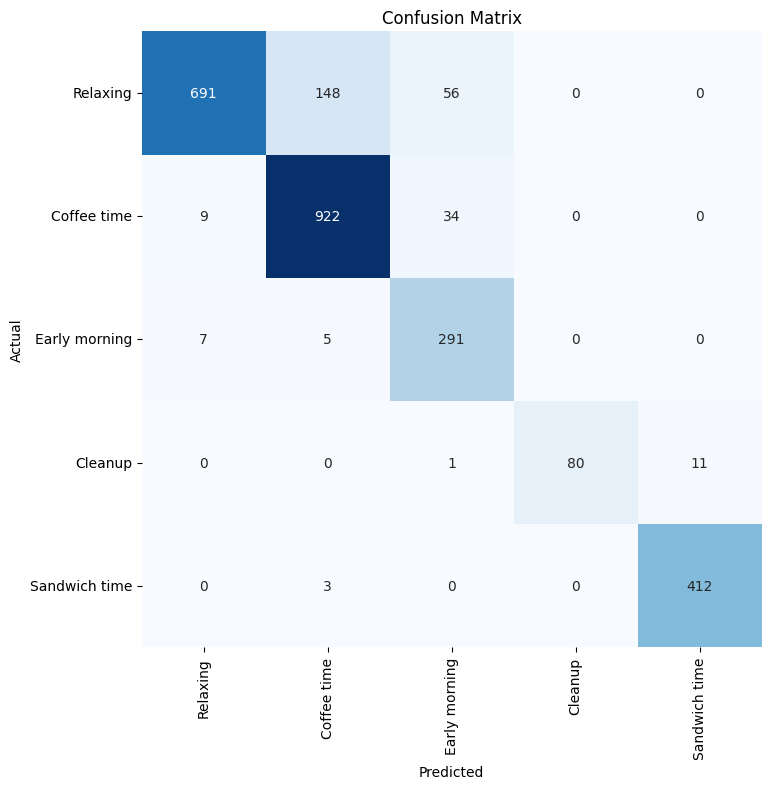

In [51]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)

# plot the confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xticks(np.arange(5)+0.5, ['Relaxing', 'Coffee time', 'Early morning', 'Cleanup', 'Sandwich time'], rotation=90)
plt.yticks(np.arange(5)+0.5, ['Relaxing', 'Coffee time', 'Early morning', 'Cleanup', 'Sandwich time'], rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()